In [1]:
# !pip install tensorflow
# !pip install keras

First, we'll import the necessary packages. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # to split into training and testing data 

import keras
from keras.preprocessing.image import ImageDataGenerator # for image processing
from keras.models import Sequential,load_model #used to build initial model 
from keras.layers import Activation, Dense, Dropout, Flatten #Dense used to add layers to model
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping 
from keras import backend as K
from keras.optimizers import SGD #this is for optimization on learning rate

In [3]:
# we will run our project from end to end with this number of images to test run time 

IMG_COUNT = 4000

### ADDITIONAL PREPROCESSING

Since the computing power on my personal laptop is limited, I will run the project end to end with a smaller amount of the image data, and will gradually increase the numbeer of images over time. 

To this end, we'll import our original file, and grab a random sample of images to train, validate, and test on. Further, to balance out our dataset, we'll take an equal number of images showing birds and an equal number that are not birds. 

In [4]:
# import clean annotation file
df = pd.read_csv('../data/interim/wildlife_interim.csv')

In [5]:
# get random sample of images -- half birds, and half not birds
df_bird = df[df.is_bird == 1].sample(n=int(IMG_COUNT/2), random_state=42)
df_no_bird = df[df.is_bird == 0].sample(n=int(IMG_COUNT/2),random_state=42)
df = pd.concat([df_bird, df_no_bird], axis=0)
df.is_bird = df.is_bird.astype(str)

In [6]:
# split dataframe into training, validation, and test dataframes
df_train, df_val = train_test_split(df,test_size=0.2, random_state=42)
df_train, df_test = train_test_split(df_train,test_size=0.3, random_state=42)

print("Number of Training Images: ",len(df_train))
print("Number of Validation Images: ", len(df_val))
print("Number of Test Images: ", len(df_test))

Number of Training Images:  2240
Number of Validation Images:  800
Number of Test Images:  960


### SPECIFY ARCHITECTURE 

We'll set some constant values for our model below. 

In [7]:
# Model configuration
img_dir = "../data/raw/" # where images are stored
img_width, img_height = 150,150 # resize images
batch_size = 16 # to account for small training size, can increase to 32,64,etc
no_epochs = 7 
no_classes = 2 # choices of bird or not bird
patience = 2 # used later for Early Stopping callback 

#### Augment - Training

We'll do random augmentation of our images which will help rescale them can help prevent overfitting. 

In [8]:
%%time
train_datagen = ImageDataGenerator(
                    rescale=1./255, 
                    horizontal_flip = True,    
                    zoom_range = 0.3,
                    width_shift_range = 0.3,
                    height_shift_range=0.3)


train_generator = train_datagen.flow_from_dataframe(
                    dataframe= df_train,
                    directory=img_dir,
                    x_col="file_name",
                    y_col="is_bird",
                    batch_size=batch_size,
                    shuffle=True,
                    class_mode="binary",    
                    target_size=(img_height,img_width))

Found 2240 validated image filenames belonging to 2 classes.
CPU times: user 20.8 ms, sys: 13.7 ms, total: 34.5 ms
Wall time: 69.6 ms


#### Augment - Validation and Testing

In [9]:
%%time
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(
                    dataframe=df_val,
                    directory=img_dir,
                    x_col="file_name",
                    y_col="is_bird",
                    batch_size=batch_size,
                    class_mode="binary",    
                    target_size=(img_height,img_width))

Found 800 validated image filenames belonging to 2 classes.
CPU times: user 10.6 ms, sys: 5.07 ms, total: 15.6 ms
Wall time: 19.8 ms


#### Add Layers

In [10]:
# starting with code from keras.io tutorial

'''if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
'''
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_width,img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

### COMPILE

In [11]:
%%time
# compile, and add metrics==['accuracy'] to keep track of diagnostics for each epoch
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

CPU times: user 7.36 ms, sys: 1.05 ms, total: 8.4 ms
Wall time: 7.55 ms


### FIT

In [12]:
#how many epochs to go without model improving without stopping model

early_stopping_monitor = EarlyStopping(patience=patience) 

In [13]:
%%time
history = model.fit(
    train_generator,
    steps_per_epoch= len(df_train) // batch_size,
    epochs=no_epochs,
    validation_data=valid_generator,
    validation_steps= len(df_val) // batch_size,
    callbacks=[early_stopping_monitor],
    verbose=2)

Epoch 1/7
140/140 - 45s - loss: 0.6286 - accuracy: 0.6562 - val_loss: 0.5552 - val_accuracy: 0.7387
Epoch 2/7
140/140 - 49s - loss: 0.5859 - accuracy: 0.7049 - val_loss: 0.5448 - val_accuracy: 0.7525
Epoch 3/7
140/140 - 52s - loss: 0.5928 - accuracy: 0.6991 - val_loss: 0.5903 - val_accuracy: 0.6700
Epoch 4/7
140/140 - 51s - loss: 0.5651 - accuracy: 0.7241 - val_loss: 0.5350 - val_accuracy: 0.7375
Epoch 5/7
140/140 - 52s - loss: 0.5458 - accuracy: 0.7455 - val_loss: 0.5449 - val_accuracy: 0.6950
Epoch 6/7
140/140 - 53s - loss: 0.5452 - accuracy: 0.7424 - val_loss: 0.4915 - val_accuracy: 0.7688
Epoch 7/7
140/140 - 52s - loss: 0.5529 - accuracy: 0.7393 - val_loss: 0.4852 - val_accuracy: 0.7763
CPU times: user 15min 34s, sys: 4min 57s, total: 20min 32s
Wall time: 5min 57s


#### Training & Validation Summary

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

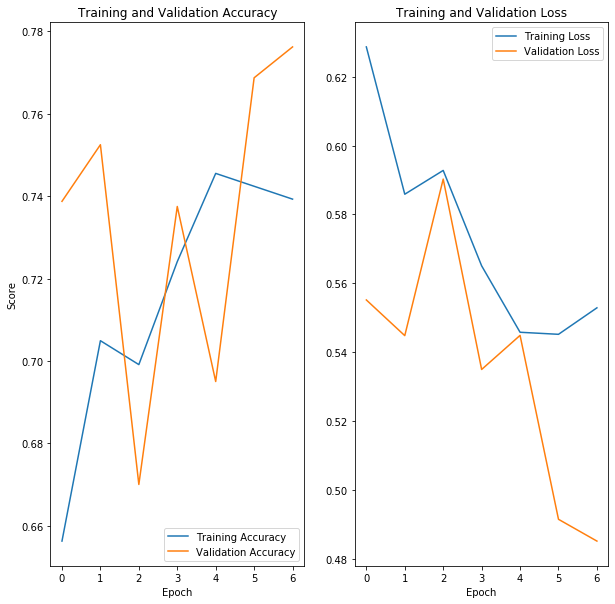

In [15]:
# training and validation accuracy graphs, from kaggle
# TO DO: find workaround to display graphs regardless of early stopping


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(no_epochs) # can break here; epochs stop at 7

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# save model
file_name = 'original_v2.h5'
model.save('../models/{}'.format(file_name))

### TO DO (IN PROGRESS):  PREDICT

In [ ]:
#TO DO: predictions

'''model_1st = load_model('../models/{}'.format(file_name)) 

predictions = model_1st.predict(df_test)

# in the example we had on datacamp, this was the second column - the probability a shot was made
probability_type = predictions[:,1] 
'''

### TO DO:  RESULTS & VISUALIZATIONS

In [ ]:
# TO DO

In [ ]:
%load_ext watermark
%watermark -a "Lab 2.0" -d -t -v -p numpy,pandas,tensorflow,keras